<h1 align=center>Traffic_sign_detector</h1>

https://medium.com/typeiqs/traffic-sign-recognition-aa38d699ac9 and <br>
https://github.com/mohamedameen93/German-Traffic-Sign-Classification-Using-TensorFlow
For more details

In [82]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator 
import pickle
import pandas as pd 
import random 
import cv2

import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [46]:
# Read data 
data = pd.read_csv('german-traffic-signs/signnames.csv') 
  
with open('german-traffic-signs/train.p', 'rb') as f: 
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f: 
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f: 
    test_data = pickle.load(f)

# Extracting the labels from the dictionaries 
X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'],val_data['labels']

print(X_train.shape)
print(len(X_train))  ## length
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

print("unique classes :" ,len(np.unique(y_train)))

(34799, 32, 32, 3)
34799
(34799,)
(12630, 32, 32, 3)
(12630,)
(4410, 32, 32, 3)
(4410,)
unique classes : 43


In [61]:
# Mapping ClassID to traffic sign names
import csv
signs = []
with open('german-traffic-signs/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row)
    csvfile.close()

In [44]:
for i in range(0,5):
    print(signs[i])

['0', 'Speed limit (20km/h)']
['1', 'Speed limit (30km/h)']
['2', 'Speed limit (50km/h)']
['3', 'Speed limit (60km/h)']
['4', 'Speed limit (70km/h)']


In [73]:
def list_images(dataset,dataset_y,y_label="",cmap=None):
    # to show images of train test and validation
    plt.figure(figsize=(15,16))
    for i in range(6):
        plt.subplot(1,6,i+1)
        index = random.randint(0,len(dataset))
        cmap = 'gray' if len(dataset[index].shape) == 2 else cmap
        plt.imshow(dataset[index],cmap=cmap)
        plt.xlabel(signs[dataset_y[index]][1])  ## modified [1] I added
        plt.ylabel(y_label)
        
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)   # unable find meaning of this line
    plt.show()
    

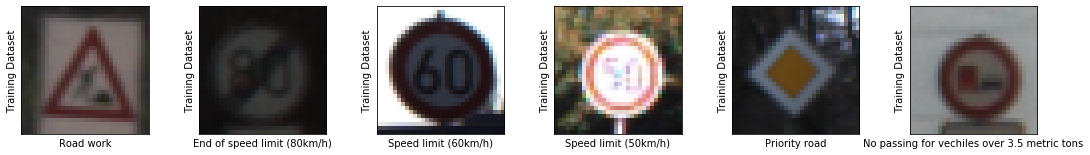

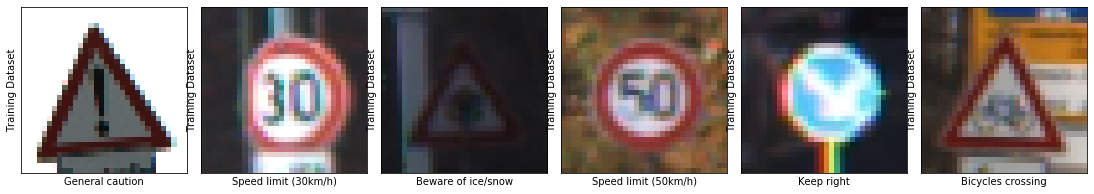

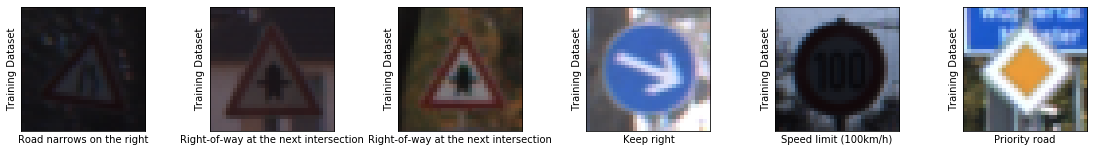

In [72]:
list_images(X_train,y_train,"Training Dataset")
list_images(X_test,y_test,"Training Dataset")
list_images(X_val,y_val,"Training Dataset")

In [76]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    n_classes = len(np.unique(dataset))
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

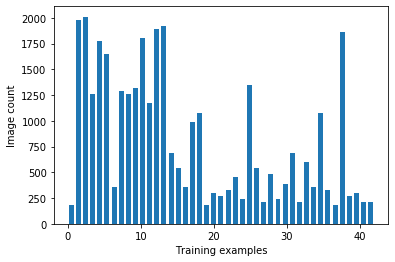

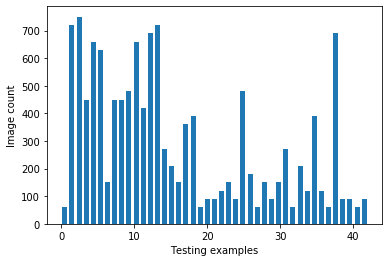

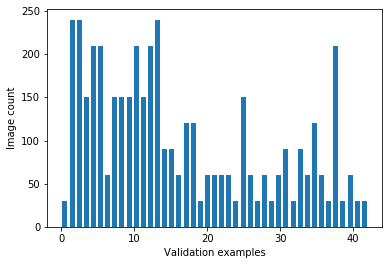

In [78]:

# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_val, "Validation examples")

<h3>We will use the following preprocessing techniques:</h3>

    1.Shuffling.
    2.Grayscaling.
    3.Local Histogram Equalization.
    4.Normalization.


In [83]:
X_train, y_train = shuffle(X_train, y_train)

In [84]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
X_train = np.array(list(map(preprocessing, X_train))) 
X_val = np.array(list(map(preprocessing, X_val))) 
X_test = np.array(list(map(preprocessing, X_test))) 
  
X_train = X_train.reshape(34799, 32, 32, 1) 
X_val = X_val.reshape(4410, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 

In [85]:
# generating the augmented images
datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 
datagen.fit(X_train) 
  
y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43) 

In [88]:
X_train.shape

(34799, 32, 32, 1)

In [97]:
num_classes = 43

def cnn_model(): 
	model = Sequential() 
	model.add(Conv2D(60, (5, 5), 
					input_shape =(32, 32, 1), 
					activation ='relu')) 
	
	model.add(Conv2D(60, (5, 5), activation ='relu')) 
	model.add(MaxPooling2D(pool_size =(2, 2))) 
	
	model.add(Conv2D(30, (3, 3), activation ='relu')) 
	model.add(Conv2D(30, (3, 3), activation ='relu')) 
	model.add(MaxPooling2D(pool_size =(2, 2))) 
	
	model.add(Flatten()) 
	model.add(Dense(500, activation ='relu')) 
	model.add(Dropout(0.5)) 
	model.add(Dense(num_classes, activation ='softmax')) 
	
	# Compile model 
	model.compile(Adam(lr = 0.001), 
				loss ='categorical_crossentropy', 
				metrics =['accuracy']) 
	return model 

model = cnn_model() 
history = model.fit_generator(datagen.flow(X_train, y_train, 
							batch_size = 50), steps_per_epoch = 2000, 
							epochs = 10, validation_data =(X_val, y_val), 
                            shuffle = 1) 


Epoch 1/10
2000/2000 [==============================] - 749s 374ms/step - loss: 0.9483 - accuracy: 0.7228 - val_loss: 0.0928 - val_accuracy: 0.9755
Epoch 2/10
2000/2000 [==============================] - 760s 380ms/step - loss: 0.2324 - accuracy: 0.9269 - val_loss: 0.0527 - val_accuracy: 0.9844
Epoch 3/10
2000/2000 [==============================] - 712s 356ms/step - loss: 0.1550 - accuracy: 0.9521 - val_loss: 0.0454 - val_accuracy: 0.9902
Epoch 4/10
2000/2000 [==============================] - 712s 356ms/step - loss: 0.1221 - accuracy: 0.9626 - val_loss: 0.0738 - val_accuracy: 0.9837
Epoch 5/10
2000/2000 [==============================] - 702s 351ms/step - loss: 0.1044 - accuracy: 0.9677 - val_loss: 0.0396 - val_accuracy: 0.9882
Epoch 6/10
2000/2000 [==============================] - 693s 347ms/step - loss: 0.0908 - accuracy: 0.9723 - val_loss: 0.0450 - val_accuracy: 0.9884
Epoch 7/10
2000/2000 [==============================] - 711s 355ms/step - loss: 0.0844 - accuracy: 0.9738 - val_

Text(0.5, 0, 'epoch')

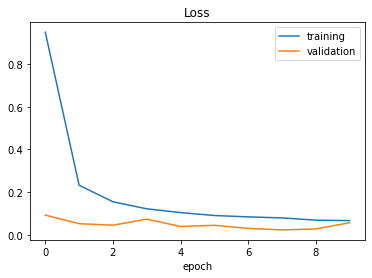

In [98]:

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['training', 'validation']) 
plt.title('Loss') 
plt.xlabel('epoch') 


Text(0.5, 0, 'epoch')

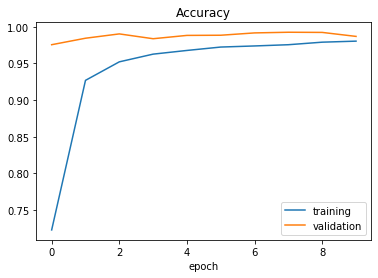

In [102]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.legend(['training', 'validation']) 
plt.title('Accuracy') 
plt.xlabel('epoch') 

In [103]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test Loss: ', score[0]) 
print('Test Accuracy: ', score[1]) 

Test Loss:  0.12216884606450484
Test Accuracy:  0.9689627885818481


In [126]:
with open(r"trained.p", "wb") as output_file:
        pickle.dump(model, output_file)

Predicted sign: Speed limit (30km/h)
Actual sign: Speed limit (30km/h)


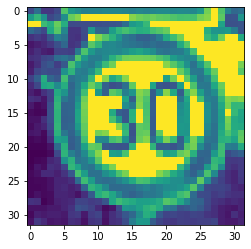

In [169]:
index = random.randint(0,len(X_test))
plt.imshow((X_test[index].reshape(32, 32)))
print("Predicted sign: "+ signs[model.predict_classes(X_test[index].reshape(1, 32, 32, 1))[0]][1])

k = np.where(y_test[index]==1)[0]
print("Actual sign: "+ signs[k[0]][1])

In [125]:
x = [2]
signs[x[0]]

['2', 'Speed limit (50km/h)']

In [172]:
!ls

1409.1556.pdf	      New_test_images		   trained.p
german-traffic-signs  Traffic_sign_detector.ipynb
